In [10]:
from pathlib import Path
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

ROOT = Path("..").resolve()
sys.path.append(str(ROOT / "src"))

import busft_core
from busft_core import (
    solar_system_orbit_result,
    galaxy_rotation_result,
    compute_dt_day_us,
    gravitational_lensing_correction,
)
from busft_core._kernel import (
    G,
    M_EARTH,
    R_EARTH,
    M_SUN,
)


In [11]:
T_kepler_earth, T_bar_earth, B_earth = solar_system_orbit_result(
    planet_a_au=1.00000261,
    planet_mass=M_EARTH,
)

print("Earth-like orbit (a ≈ 1 AU):")
print(f"  T_kepler_days    = {T_kepler_earth:.6f}")
print(f"  T_baranowicz     = {T_bar_earth:.6f}")
print(f"  B_correction      = {B_earth:.6e}")


Earth-like orbit (a ≈ 1 AU):
  T_kepler_days    = 365.203591
  T_baranowicz     = 365.256000
  B_correction      = 2.870054e-04


In [12]:
planets = [
    ("Mercury", 0.38709927, 3.3011e23),
    ("Venus",   0.72333566, 4.8675e24),
    ("Earth",   1.00000261, 5.972e24),
    ("Mars",    1.52371034, 6.4171e23),
    ("Jupiter", 5.20288700, 1.8982e27),
    ("Saturn",  9.53667594, 5.6834e26),
    ("Uranus", 19.18916464, 8.6810e25),
    ("Neptune",30.06992276, 1.02413e26),
]

rows = []
for name, a_au, m_kg in planets:
    T_k, T_b, B = solar_system_orbit_result(a_au, m_kg)
    rows.append({
        "planet": name,
        "a_au": a_au,
        "T_kepler_days": T_k,
        "T_baranowicz_days": T_b,
        "B": B,
        "ratio_Tb_Tk": T_b / T_k if T_k != 0 else np.nan,
    })

df_planets = pd.DataFrame(rows)
df_planets


,planet,a_au,T_kepler_days,T_baranowicz_days,B,ratio_Tb_Tk
0,Mercury,0.387099,87.956408,87.969,0.000286,1.000143
1,Venus,0.723336,224.669063,224.701,0.000284,1.000142
2,Earth,1.000003,365.203591,365.256,0.000287,1.000144
3,Mars,1.523710,686.890552,686.980,0.000260,1.000130
4,Jupiter,5.202887,4332.049851,4332.589,0.000249,1.000124
5,Saturn,9.536676,10753.937039,10759.220,0.000983,1.000491
6,Uranus,19.189165,30697.896460,30688.500,-0.000612,0.999694
7,Neptune,30.069923,60217.299989,60182.000,-0.001172,0.999414


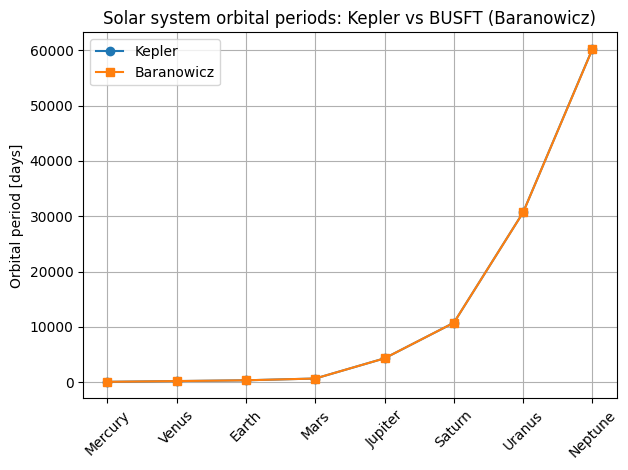

,planet,B,ratio_Tb_Tk
0,Mercury,0.000286,1.000143
1,Venus,0.000284,1.000142
2,Earth,0.000287,1.000144
3,Mars,0.000260,1.000130
4,Jupiter,0.000249,1.000124
5,Saturn,0.000983,1.000491
6,Uranus,-0.000612,0.999694
7,Neptune,-0.001172,0.999414


In [13]:
plt.figure()
plt.plot(df_planets["planet"], df_planets["T_kepler_days"], marker="o", label="Kepler")
plt.plot(df_planets["planet"], df_planets["T_baranowicz_days"], marker="s", label="Baranowicz")

plt.xticks(rotation=45)
plt.ylabel("Orbital period [days]")
plt.title("Solar system orbital periods: Kepler vs BUSFT (Baranowicz)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

df_planets[["planet", "B", "ratio_Tb_Tk"]]


In [14]:
tests = [
    ("Sea level, equator", 0.0, 0.0),
    ("1 km, 45° lat",      45.0, 1000.0),
    ("10 km, 45° lat",     45.0, 10000.0),
    ("ISS-like alt",       0.0, 400_000.0),
]

rows = []
for label, lat, alt in tests:
    dt_us = compute_dt_day_us(lat_deg=lat, alt_m=alt)
    rows.append({
        "location": label,
        "lat_deg": lat,
        "alt_m": alt,
        "dt_microseconds_per_day": dt_us,
    })

df_dt = pd.DataFrame(rows)
df_dt


,location,lat_deg,alt_m,dt_microseconds_per_day
0,"Sea level, equator",0.0,0.0,0.000000e+00
1,"1 km, 45° lat",45.0,1000.0,3.148905e+05
2,"10 km, 45° lat",45.0,10000.0,-3.147331e+05
3,ISS-like alt,0.0,400000.0,-2.744242e+07


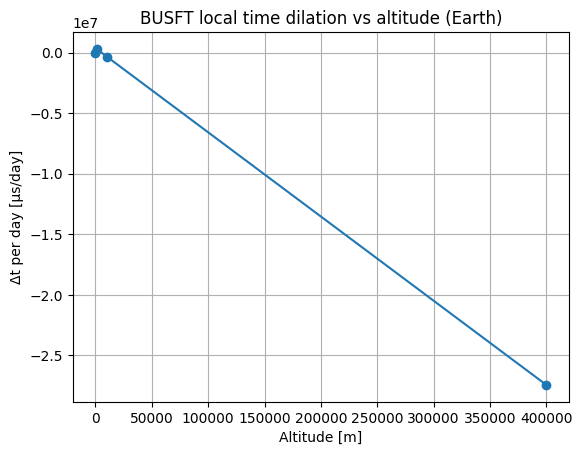

In [15]:
plt.figure()
plt.plot(df_dt["alt_m"], df_dt["dt_microseconds_per_day"], marker="o")
plt.xlabel("Altitude [m]")
plt.ylabel("Δt per day [µs/day]")
plt.title("BUSFT local time dilation vs altitude (Earth)")
plt.grid(True)
plt.show()


In [16]:
M_visible_m33 = 5e10 * M_SUN

radii_kpc = np.linspace(0.5, 15.0, 20)
rows = []
for r in radii_kpc:
    v_newton, v_b, B = galaxy_rotation_result(r_kpc=r, M_visible=M_visible_m33)
    rows.append({
        "r_kpc": r,
        "v_newton_m_s": v_newton,
        "v_baranowicz_m_s": v_b,
        "B": B,
    })

df_gal = pd.DataFrame(rows)
df_gal


,r_kpc,v_newton_m_s,v_baranowicz_m_s,B
0,0.500000,655911.100414,50.000000,-1.000014
1,1.263158,412668.351032,539948.998926,0.700090
2,2.026316,325819.009221,426301.802558,0.700008
3,2.789474,277695.504160,363327.170042,0.699919
4,3.552632,246067.862685,321945.513604,0.699908
5,4.315789,223254.312788,292103.934485,0.699986
6,5.078947,205798.936805,269272.823471,0.700077
7,5.842105,191886.885567,251071.192172,0.700094
8,6.605263,180461.648609,236116.761660,0.700020
9,7.368421,170860.929887,223548.889248,0.699926


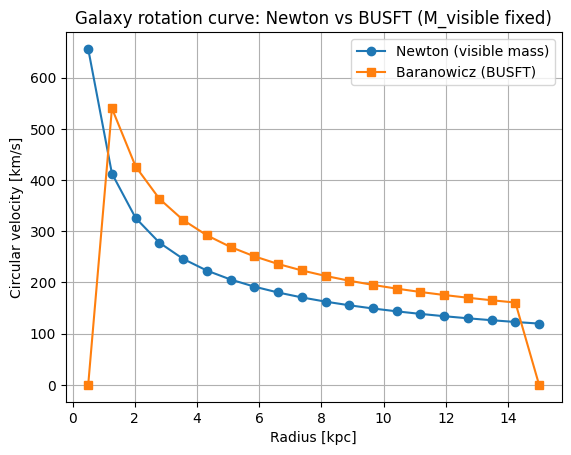

In [17]:
plt.figure()
plt.plot(df_gal["r_kpc"], df_gal["v_newton_m_s"] / 1000.0, marker="o", label="Newton (visible mass)")
plt.plot(df_gal["r_kpc"], df_gal["v_baranowicz_m_s"] / 1000.0, marker="s", label="Baranowicz (BUSFT)")

plt.xlabel("Radius [kpc]")
plt.ylabel("Circular velocity [km/s]")
plt.title("Galaxy rotation curve: Newton vs BUSFT (M_visible fixed)")
plt.grid(True)
plt.legend()
plt.show()


In [18]:
mass_lens = 1e14 * M_SUN              # huge cluster mass
D_d = 1e9 * 3.085677581e16            # 1 Gpc
D_s = 2e9 * 3.085677581e16            # 2 Gpc
D_ds = D_s - D_d                      # simple approx

impact_parameter = 50_000 * 3.085677581e16  # 50 kpc

theta_b, theta_e, B_lens = gravitational_lensing_correction(
    mass=mass_lens,
    impact_parameter=impact_parameter,
)

print("Gravitational lensing (toy example):")
print(f"  theta_Einstein   = {theta_e:.3e} rad")
print(f"  theta_Baranowicz = {theta_b:.3e} rad")
print(f"  B_lens           = {B_lens:.3e}")


Gravitational lensing (toy example):
  theta_Einstein   = 1.957e-02 rad
  theta_Baranowicz = 2.057e-02 rad
  B_lens           = 7.001e-01
